In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/no_LLM_ViT_20241223/lr_1e-06_visual_feature_extractor_ViT_LLM_loaded_False/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()


In [6]:
def model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, target = data.cuda(), target.cuda().long()
            output = model(data)
            # output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
            
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

In [18]:
data = pd.read_csv(parameters['placepulse_datapath'])
data_ls = data[data['label'] != 0]
data_ls.loc[data_ls[data_ls['label'] == -1].index, 'label'] = 0
transform = get_transforms((224,224))
train_num = int(len(data_ls) * 0.6)
valid_num = int(len(data_ls) * 0.2)


LLM_pre_extractor = None
train_dataset = SafetyPerceptionDataset(data_ls[:train_num], transform=transform, paras=parameters)
valid_dataset = SafetyPerceptionDataset(data_ls[train_num:train_num+valid_num], transform=transform, paras=parameters)
test_dataset = SafetyPerceptionDataset(data_ls[train_num+valid_num:], transform=transform, paras=parameters)
total_dataset = SafetyPerceptionDataset(data, transform=transform, paras=parameters)
    
total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=parameters['batch_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=parameters['batch_size'])
extractor = Extractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
adaptor = Adaptor(input_dim=parameters['input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
classifier = Classifier(input_dim=parameters['adaptor_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
model = FullModel(extractor, adaptor, classifier).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load(model_path), strict=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [19]:
all_outputs, all_labels = model_test(model, total_loader)
# valid_outputs, valid_labels = model_test(model, valid_loader)

100%|██████████| 112/112 [00:54<00:00,  2.06it/s]


In [20]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()

In [22]:
data['final_outputs'] = final_outputs

In [36]:
data['log_final_outputs'] = np.log(data['final_outputs'])
data['log_score'] = np.log(data['Score'])

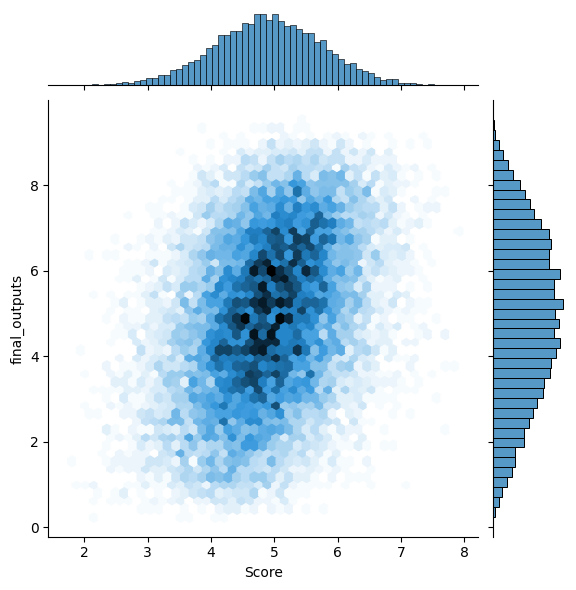

In [46]:
# sns.scatterplot(data=data, x='Score', y='final_outputs')
# sns.jointplot(data=data, x='Score', y='final_outputs', line_kws={"label":f"R2 Score: {r2_score(data['Score'], data['final_outputs']):.2f}"})
sns.jointplot(data=data, x='Score', y='final_outputs', kind='hex')
# plt.legend()

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label
0,0,KtHXnMKIroDc_BK-EePEww,22.310002,114.171100,2009.0,1.0,10,1
1,1,uaWZV0lCAQRN4qCbvBy-uQ,22.310017,114.171079,2009.0,9.0,10,1
2,2,z39LXK-I0_FXEzPSFD4QUQ,22.309992,114.171083,2011.0,2.0,10,1
3,3,iN2ZLjRQCcddBoZLzXwRWA,22.309993,114.171079,2011.0,8.0,10,1
4,4,ZU_JDaoWqgp1wFT9Z_WB5Q,22.310023,114.171109,2017.0,1.0,10,1
...,...,...,...,...,...,...,...,...
683196,683196,WbJQrhfs_OiojpcIkf_YbA,22.434206,114.024910,NaN,NaN,23511,1
683197,683197,QyXxNVkfd4j8ampaLEYIyg,22.434200,114.024810,NaN,NaN,23511,1
683198,683198,EEshehKUF9nHwvYKQfjwuA,22.434916,114.025036,NaN,NaN,23511,1
683199,683199,AktfR4y5OH5ve5fbGwwnOg,22.434748,114.025051,NaN,NaN,23511,1


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/no_LLM_ViT_20241223/lr_1e-06_visual_feature_extractor_ViT_LLM_loaded_False/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()

def model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target, _ in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            # Ensure all images have 3 channels
            data, target = data.cuda(), target.cuda().long()
            output = model(data)
            # output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
            
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

In [3]:
extractor = Extractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
adaptor = Adaptor(input_dim=parameters['input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
classifier = Classifier(input_dim=parameters['adaptor_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
model = FullModel(extractor, adaptor, classifier).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load(model_path), strict=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [38]:
HK_data = pd.read_csv('/data2/cehou/LLM_safety/GSV/GSV_metadata_sampled_10000_20241220.csv')
HK_data['label'] = 1
HK_data.rename(columns={'panoid':'Image_ID'}, inplace=True)
HK_data = HK_data[~HK_data['Image_ID'].str.startswith('AF1Q')]
transform = get_transforms((224,224))
parameters['batch_size'] = 256
HK_dataset = SafetyPerceptionDataset(HK_data, transform=transform, paras=parameters)
HK_loader = torch.utils.data.DataLoader(HK_dataset, batch_size=parameters['batch_size'])
all_outputs, all_labels = model_test(model, HK_loader)

# HK_data = pd.read_pickle(HK_dataset)
# HK_data.to_csv('/data2/cehou/LLM_safety/PlacePulse2.0/HK_metadata.csv')

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [01:14<00:00,  1.87s/it]


In [ ]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()
HK_data['final_outputs'] = final_outputs

In [56]:
HK_data.merge(HK_total, on=['lat', ['lon', ]], how='left')

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label,final_outputs
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885


In [57]:
HK_roads = gpd.read_file("/data_nas/GoogleSV/metadata/China/HongKong/edges.shp")
HK_safety_perception_sampled = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")
HK_roads = HK_roads.reset_index().rename(columns={'index':'id'})
# HK_safety_perception_sampled.drop(['geometry'], axis=1, inplace=True)
HK_road_merge = HK_safety_perception_sampled.merge(HK_roads[['id', 'geometry']], on='id', how='left')
HK_road_merge = HK_road_merge.drop(['Unnamed_ 0','geometry_x'],axis=1).rename(columns={'geometry_y':'geometry'})

In [58]:
# Group by 'id' and calculate the mean of 'final_outp'
average_final_outp = HK_road_merge.groupby('id')['final_outp'].mean().reset_index()

# Rename the column to indicate it's an average
average_final_outp.rename(columns={'final_outp': 'average_final_outp'}, inplace=True)
HK_road_merge_new = HK_road_merge.merge(average_final_outp, on='id', how='inner')
HK_road_merge_new = gpd.GeoDataFrame(HK_road_merge_new, crs='EPSG:4326', geometry='geometry')
HK_road_merge_new.drop_duplicates(subset=['id'], inplace=True)

In [63]:
HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")

/tmp/ipykernel_12116/3714306485.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")


In [19]:
import pandas as pd
aaa = pd.read_pickle("/data_nas/GoogleSV/metadata/China/HongKong/download_pano_2024-08-17 13:11:09.125553_23512.p")
aaa[aaa['panoid'] == "LhDzohF2sf0z5MOC8WvTlw"]

,panoid,lat,lon,year,month,id,download
514155,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.12836,NaN,NaN,16920,True


In [14]:
from shapely.geometry import Point

# Create a function to check if a point is on any of the lines in the GeoDataFrame
def is_point_on_line(point, lines):
    for line in lines.geometry:
        if line.contains(point):
            return True
    return False
HK_safety_perception_sampled_test = HK_safety_perception_sampled.sample(10)
# Apply the function to each point in HK_safety_perception_sampled
HK_safety_perception_sampled['on_line'] = HK_safety_perception_sampled['geometry'].apply(lambda x: is_point_on_line(x, HK_roads))

# Display the updated DataFrame
HK_safety_perception_sampled

KeyboardInterrupt: 

In [52]:
import geopandas as gpd
HK_data_gpd = gpd.GeoDataFrame(HK_data, geometry=gpd.points_from_xy(HK_data['lon'], HK_data['lat']))
HK_data_gpd.set_crs(epsg=4326, inplace=True)
# HK_data_gpd.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label,final_outputs,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [1]:
import geopandas as gpd

gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed_ 0,Image_ID,lat,lon,year,month,id,label,final_outp,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [80]:
nodes, _ = get_graph_node_names(model)
# print(nodes)
feature_extracter = create_feature_extractor(model, return_nodes={'adaptor.layer_norm': 'features'})
all_outputs, all_labels = model_test(feature_extracter, train_loader)
valid_outputs, valid_labels = model_test(feature_extracter, valid_loader)

all_outputs, all_labels = all_outputs.cpu().numpy(), all_labels.cpu().numpy()
valid_outputs, valid_labels = valid_outputs.cpu().numpy(), valid_labels.cpu().numpy()

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# 创建随机森林分类器

def ml_classifier(train_data, train_labels, validate_data, validate_labels, ml_tools):
    if ml_tools == 'random forest':
        ml_model = RandomForestClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'svm':
        ml_model = SVC(kernel='rbf', random_state=42) # kernel=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    if ml_tools == 'logistic':
        ml_model = LogisticRegression(random_state=42)    
    if ml_tools == 'xgboost':
        ml_model = XGBClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'mlp':
        ml_model = MLPClassifier(hidden_layer_sizes=(1024, 512), max_iter=100)
    
    ml_model.fit(train_data, train_labels)
    predictions = ml_model.predict(validate_data)
    accuracy = accuracy_score(validate_labels, predictions)
    print(f"Accuracy: {accuracy:.2f}, R2 score: {r2_score(validate_labels, predictions):.2f}, f1 score: {f1_score(validate_labels, predictions):.2f}")
    print(classification_report(validate_labels, predictions))
    return predictions

predictions = ml_classifier(all_outputs, all_labels, valid_outputs, valid_labels, 'xgboost')

Accuracy: 0.65, R2 score: -0.39, f1 score: 0.67
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       884
           1       0.64      0.70      0.67       869

    accuracy                           0.65      1753
   macro avg       0.65      0.65      0.65      1753
weighted avg       0.65      0.65      0.65      1753



: 

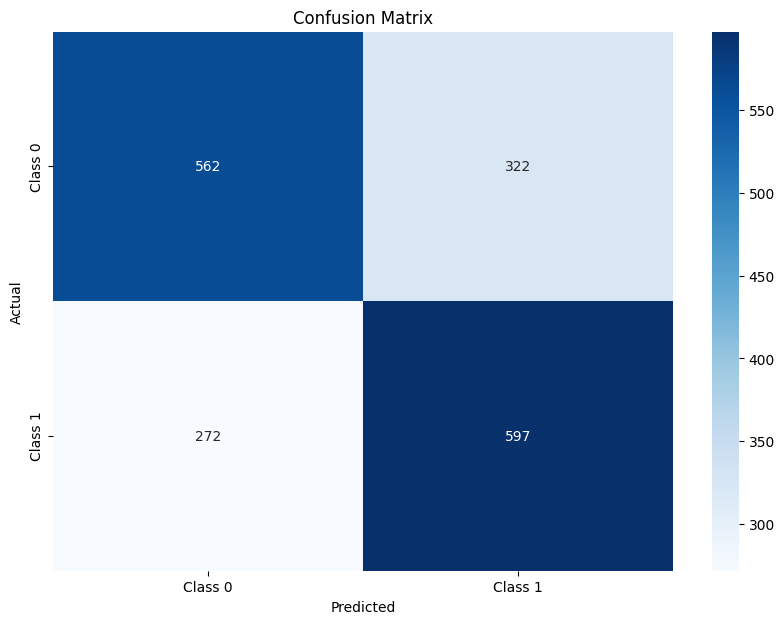

In [110]:
# 计算混淆矩阵
cm = confusion_matrix(valid_labels, predictions)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


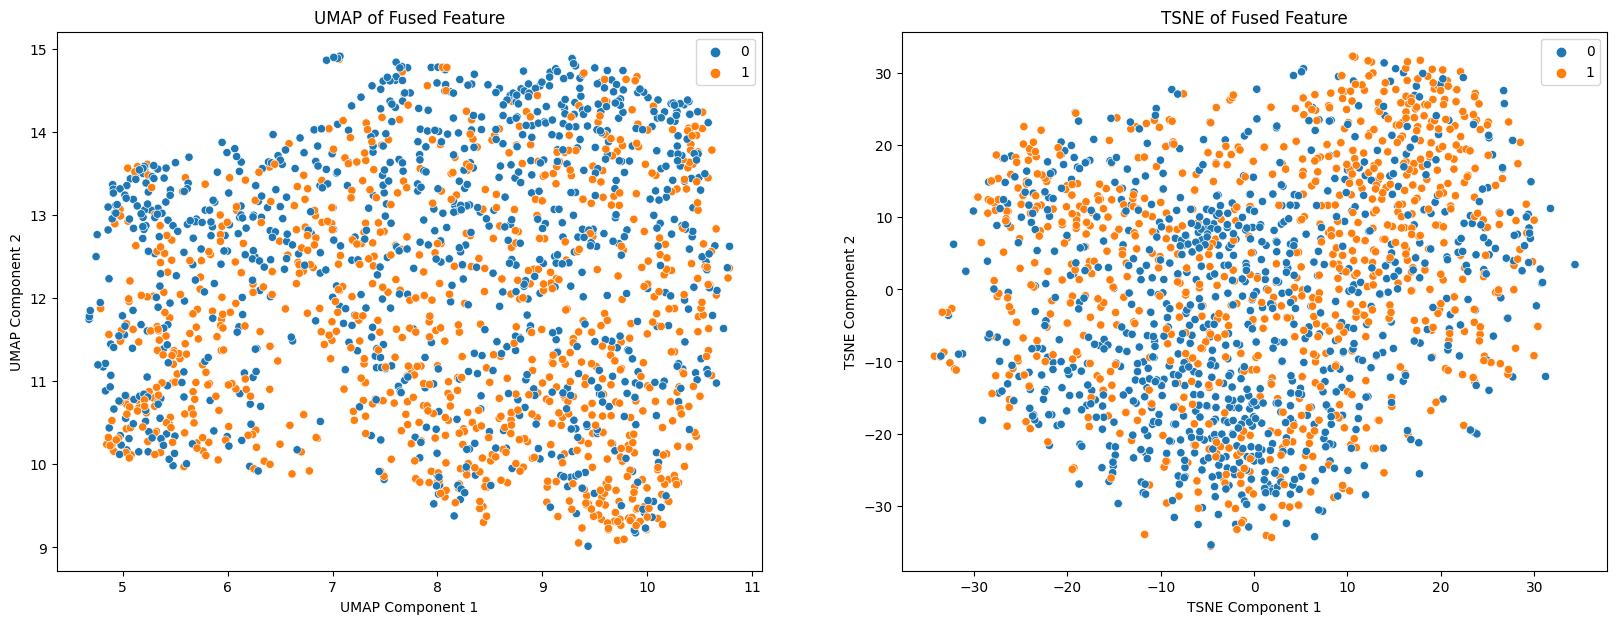

In [99]:
# %pip install umap-learn

import umap.umap_ as umap
from sklearn.manifold import TSNE

# 使用UMAP降维
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(valid_outputs)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(valid_outputs)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(x=umap_results[:,0], y=umap_results[:,1], hue=valid_labels, ax=ax[0])
ax[0].set_title("UMAP of Fused Feature")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=valid_labels, ax=ax[1])
ax[1].set_title("TSNE of Fused Feature")
ax[1].set_xlabel("TSNE Component 1")
ax[1].set_ylabel("TSNE Component 2")
plt.show()


Text(0.5, 1.0, 'PCA of Fused Feature')

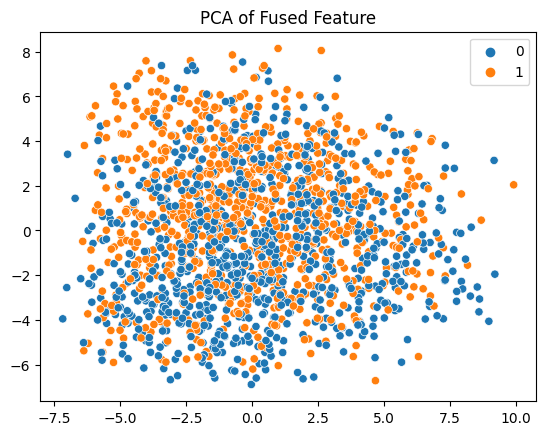

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined_feature_pca = pca.fit_transform(valid_outputs)

sns.scatterplot(x=combined_feature_pca[:,0], y=combined_feature_pca[:,1], hue=valid_labels)
plt.title("PCA of Fused Feature")

In [ ]:
# 使用shap计算每个维度的贡献
import shap

# 使用训练数据创建一个 SHAP explainer
explainer = shap.Explainer(mlp_classifier, X_train)
# explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_valid)

shap_values_overall = shap_values[0] + shap_values[1]
shap_values_sum = shap_values_overall.sum(axis=0).reshape(-1, 1)
print(f"image contribution: {shap_values_sum[:256].sum() / shap_values_sum.sum():.02%}, text contribution: {shap_values_sum[256:].sum() / shap_values_sum.sum():.02%}")

# 绘制 SHAP summary plot
# shap.summary_plot(shap_values, X_valid, feature_names=[f'Feature {i}' for i in range(X_valid.shape[1])])

In [ ]:


# # Example usage
# image_encoder = ImageEncoder(cfg_paras)
# text_encoder = TextEncoder(cfg_paras)
# fusion_model = AttentionalFeatureFusion(image_dim=cfg_paras['image_embedding'], text_dim=cfg_paras['text_embedding'], projection_dim=cfg_paras['projection_dim'])

# # Assuming we have image and text inputs
# image_input = torch.randn(1, 3, 112, 112).to(cfg_paras['device'])
# text_input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]]).to(cfg_paras['device'])
# text_attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]]).to(cfg_paras['device'])

# image_features = image_encoder(image_input)
# text_features = text_encoder(text_input_ids, text_attention_mask)

# fused_features = fusion_model(image_features, text_features)
# print(fused_features)